# Final Project: Data Analysis
## Calvin, Jack

## Data:
1. Climate_Data.xml: This is data on the Global temperature Anomalies compared to the set average from 1901 - 2010 
- NOAA National Centers for Environmental Information, Climate at a Glance: Global Time Series, published March 2023, retrieved on March 29, 2023, from https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/global/time-series
- We know this data is available since we were given the option to download right on the webiste ... it is available because of the Freedom of Information Act. https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/global/time-series
2. Disaster_Data.html(broken up into the different decades): Data on the decade average deaths per country for different types of natural disasters.
- Hannah Ritchie, Pablo Rosado and Max Roser (2022) - "Natural Disasters". Published online at OurWorldInData.org. Retrieved from: 'https://ourworldindata.org/natural-disasters' 
- This Data is free for us to use since we arent connecting to the website ... "All visualizations, data, and code produced by Our World in Data are completely open access under the Creative Commons BY license"


## Central Questions:
1. Have natural disasters become worse over the decades as Global warming has increased?
- Measured by comparing the number of deaths from natural disasters by Decade

2. Which natural disasters have grown the most in severity? 
- Measured by the number of deaths over time

## How we plan to use the data
Using this data we hope to gather concrete answers for our two central questions. For our first central questing We plan to clean up our data in order to make a comparison between how far the temperature anomalies from the climate data and how many deaths there have been over the decades. For second question inorder to answer we first need to break up our natural disaster data into overall deaths per the different disaster. Once we have it organized in this way we can compare the amount of deaths from the start of data collection to the end and see which natural disasters death rates have grown the most.

# Context to the Questions
It seems like everyday there is a new article or news story about how climate change is getting worse. Just recently the Willow project in Alaska was approved by the Biden administration. The Goal of this project is to see just how much worse it is getting. Using our data we want to see how many more people are dying from natural disasters today compared to in 1900. We obviously need to first see if there is a connection between climate change and natural disaster severity. This could give a quantifyable answer to one part of the question.

Willow project approval: https://www.npr.org/2023/03/13/1163075377/willow-drilling-project-alaska-approved-biden

### Code Libraries

In [1]:
from lxml import etree
from lxml import html
import os.path as osp
import pandas as pd
import importlib
import sqlalchemy as sa
import io
import sys
import os
import json
import matplotlib.pyplot as plt

datadir = "Data"
htmlparser =  etree.HTMLParser()

%load_ext sql

### Code_Segment: 1
Set Credentials

In [2]:
def getsqlite_creds(dirname=".",filename="creds.json",source="sqlite"):
    """ Using directory and filename parameters, open a credentials file
        and obtain the two parts needed for a connection string to
        a local provider using the "sqlite" dictionary within
        an outer dictionary.  
        
        Return a scheme and a dbfile
    """
    assert osp.isfile(osp.join(dirname, filename))
    with open(osp.join(dirname, filename)) as f:
        D = json.load(f)
    sqlite = D[source]
    return sqlite["scheme"], sqlite["dbdir"], sqlite["database"]


scheme, dbdir, database = getsqlite_creds(source = "sqlite_weather")
template = '{}:///{}/{}.db'
cstring = template.format(scheme, dbdir, database)
print("Connection string:", cstring)

Connection string: sqlite:///./Proj_DB/Weather.db


### Code_segment: 2
Set connection from client to server

In [3]:
%sql $cstring

### Code_Segment: 3
Query to change our data in the Anomalies table into decade based data

In [4]:
query0 = """
SELECT CAST((year - 1900) / 10 AS INTEGER) * 10 + 1900 AS Decade, AVG(Anomaly) AS Anomaly
FROM Anomalies
WHERE year >= 1900
GROUP BY Decade
ORDER BY Decade
"""

resultset = %sql $query0
resultset.DataFrame()

 * sqlite:///./Proj_DB/Weather.db
Done.


,Decade,Anomaly
0,1900,-0.282000
1,1910,-0.301000
2,1920,-0.210000
3,1930,-0.090000
4,1940,0.077000
5,1950,-0.011000
6,1960,0.004000
7,1970,0.072000
8,1980,0.283000
9,1990,0.408000


### Code_Segment: 4
Now that we have the above query we can outer join with Disasters to do some analysis

In [5]:
query1 = """
SELECT di.`Natural Disasters`, di.Deaths, di.Country, di.Decade, an.Anomaly
From (SELECT CAST((year - 1900) / 10 AS INTEGER) * 10 + 1900 AS Decade, AVG(Anomaly) AS Anomaly
    FROM Anomalies
    WHERE year >= 1900
    GROUP BY Decade
    ORDER BY Decade) AS an LEFT JOIN Disasters AS di USING(Decade)
UNION
SELECT di.`Natural Disasters`, di.Deaths, di.Country, di.Decade, an.Anomaly
FROM Disasters AS di LEFT JOIN (SELECT CAST((year - 1900) / 10 AS INTEGER) * 10 + 1900 AS Decade, AVG(Anomaly) AS Anomaly
FROM Anomalies
WHERE year >= 1900
GROUP BY Decade
ORDER BY Decade) AS an USING(Decade)
"""

Combined = %sql $query1
Combined.DataFrame()

 * sqlite:///./Proj_DB/Weather.db
Done.


,Natural Disasters,Deaths,Country,Decade,Anomaly
0,Drought,0,Afghanistan,1900,-0.282000
1,Drought,0,Afghanistan,1910,-0.301000
2,Drought,0,Afghanistan,1920,-0.210000
3,Drought,0,Afghanistan,1930,-0.090000
4,Drought,0,Afghanistan,1940,0.077000
...,...,...,...,...,...
33600,Wildfires,920,World,2020,0.926667
33601,Wildfires,1000,United States,1910,-0.301000
33602,Wildfires,1073,High-income countries,1910,-0.301000
33603,Wildfires,1073,North America,1910,-0.301000


### Code_Segment: 5
Beginning Analysis for the first Central Question 

In [6]:
query2 = """
SELECT SUM(Deaths) AS Total_Deaths, Country, Decade, Anomaly
FROM(SELECT di.`Natural Disasters`, di.Deaths, di.Country, di.Decade, an.Anomaly
From (SELECT CAST((year - 1900) / 10 AS INTEGER) * 10 + 1900 AS Decade, AVG(Anomaly) AS Anomaly
    FROM Anomalies
    WHERE year >= 1900
    GROUP BY Decade
    ORDER BY Decade) AS an LEFT JOIN Disasters AS di USING(Decade)
UNION
SELECT di.`Natural Disasters`, di.Deaths, di.Country, di.Decade, an.Anomaly
FROM Disasters AS di LEFT JOIN (SELECT CAST((year - 1900) / 10 AS INTEGER) * 10 + 1900 AS Decade, AVG(Anomaly) AS Anomaly
FROM Anomalies
WHERE year >= 1900
GROUP BY Decade
ORDER BY Decade) AS an USING(Decade))
WHERE Country = 'World' AND Decade <= 2010
GROUP BY Decade
ORDER BY Decade
"""

Q = %sql $query2
World = Q.DataFrame()
World

 * sqlite:///./Proj_DB/Weather.db
Done.


,Total_Deaths,Country,Decade,Anomaly
0,1472407,World,1900,-0.282
1,324304,World,1910,-0.301
2,5238918,World,1920,-0.210
3,4627976,World,1930,-0.090
4,3865921,World,1940,0.077
5,2127463,World,1950,-0.011
6,1740780,World,1960,0.004
7,1740780,World,1970,0.072
8,750103,World,1980,0.283
9,433587,World,1990,0.408


### Code_Segmemt: 6
Graph the amount of Deaths compared to the temp Anomaly over the Decades

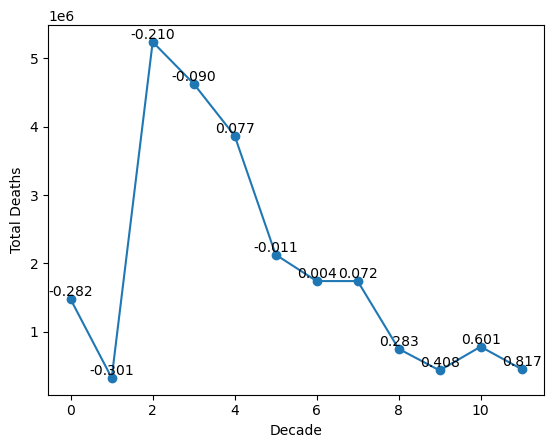

In [7]:
"""Create a graph of Total_Deaths over the decades"""
plt.plot(World['Total_Deaths'], '-o')

"""Set the x-axis and y-axis labels"""
plt.xlabel('Decade')
plt.ylabel('Total Deaths')

"""Add Anomaly information to the graph"""
for i, anomaly in enumerate(World['Anomaly']):
    plt.text(i, World['Total_Deaths'][i], '{:.3f}'.format(anomaly), ha='center', va='bottom')

"""Show the plot"""
plt.show()

## Conclusion: 1

For our central question, Have natural disasters become worse over the decades as Global warming has increased? Natural Disasters Have not become worse over the Decades. From the Graph we can see that the Deaths Have been on a steep decline since 1920(2). We cut off the 2020 decade since the data on that is incomplete.

### Code_Segment: 7
Beginning to answer Central question 2 by using a similar query just changing What is selected

In [8]:
query3 = """
SELECT `Natural Disasters`, Deaths, Decade
FROM(SELECT di.`Natural Disasters`, di.Deaths, di.Country, di.Decade, an.Anomaly
From (SELECT CAST((year - 1900) / 10 AS INTEGER) * 10 + 1900 AS Decade, AVG(Anomaly) AS Anomaly
    FROM Anomalies
    WHERE year >= 1900 
    GROUP BY Decade
    ORDER BY Decade) AS an LEFT JOIN Disasters AS di USING(Decade)
UNION
SELECT di.`Natural Disasters`, di.Deaths, di.Country, di.Decade, an.Anomaly
FROM Disasters AS di LEFT JOIN (SELECT CAST((year - 1900) / 10 AS INTEGER) * 10 + 1900 AS Decade, AVG(Anomaly) AS Anomaly
FROM Anomalies
WHERE year >= 1900 
GROUP BY Decade
ORDER BY Decade) AS an USING(Decade))
WHERE Country = 'World' and Decade <= 2010
"""

Q2 = %sql $query3
Time = Q2.DataFrame()
Time

 * sqlite:///./Proj_DB/Weather.db
Done.


,Natural Disasters,Deaths,Decade
0,Drought,0,1930
1,Drought,0,1950
2,Drought,1126,2000
3,Drought,3134,1990
4,Drought,20120,2010
...,...,...,...
127,Wildfires,396,1980
128,Wildfires,629,2000
129,Wildfires,859,1990
130,Wildfires,881,2010


### Code_Segement: 8
Make a graph for our 2nd central question

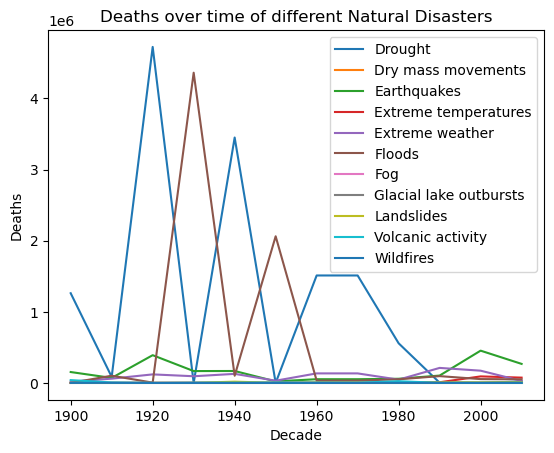

In [9]:
"""group data by Natural Disasters and Decade, and sum the Deaths"""
df_grouped = Time.groupby(['Natural Disasters', 'Decade']).agg({'Deaths': 'sum'}).reset_index()

"""create a list of unique Natural Disasters in the data"""
natural_disasters = Time['Natural Disasters'].unique()

"""create a separate line plot for each Natural Disaster"""
for disaster in natural_disasters:
    """filter data for the current disaster"""
    data = df_grouped[df_grouped['Natural Disasters'] == disaster]
    
    """create a line plot"""
    plt.plot(data['Decade'], data['Deaths'], label = disaster)

"""add axis labels and title"""
plt.xlabel('Decade')
plt.ylabel('Deaths')
plt.title('Deaths over time of different Natural Disasters')

"""add a legend"""
plt.legend()

"""show the plot"""
plt.show()


## Central Conclusion: 2

From the Graph we can see that in the end earthquakes are the most dangerous Natural disasters out of the list. But eartly on Drought Killed the most. dropped 2020 due to incomplete data.